In [2]:
import warnings
warnings.simplefilter(action="ignore", category=UserWarning)

import pandas as pd
import psycopg

db = psycopg.connect("dbname=next host=localhost port=5432 user=postgres password=postgres")

factions = pd.read_sql_query("select * from open_discourse.factions", db)
print(factions)

    id  abbreviation                                          full_name
0   -1     not found                                          not found
1    0           AfD                        Alternative für Deutschland
2    1           BHE      Block der Heimatvertriebenen und Entrechteten
3    2            BP                                       Bayernpartei
4    3         Grüne                              Bündnis 90/Die Grünen
5    4       CDU/CSU  Christlich Demokratische Union Deutschlands/Ch...
6    5            DA                  Demokratische Arbeitsgemeinschaft
7    6    DIE LINKE.                                         DIE LINKE.
8    7            DP                                    Deutsche Partei
9    8        DP/DBP             Deutsche Partei/Deutsche Partei Bayern
10   9        DP/FVP                  Deutsche Partei/Freie Volkspartei
11  10           DPB                             Deutsche Partei Bayern
12  11           DRP                              Deutsche Refor

In [3]:
speeches = pd.read_sql_query("select * from open_discourse.speeches limit 10", db)
print(speeches)

   id  session  electoral_term first_name last_name  politician_id  \
0   0        2               1               Köhler       11001150   
1   1        2               1               Arnold             -1   
2   2        2               1               Köhler       11001150   
3   3        2               1                Heuss             -1   
4   4        2               1               Köhler       11001150   
5   5        2               1                Heuss             -1   
6   6        3               1               köhler       11001150   
7   7        3               1             adenauer       11000009   
8   8        3               1               köhler       11001150   
9   9        4               1               köhler       11001150   

                                      speech_content  faction_id  \
0  Meine Damen und Herren! Ich eröffne die 2. Sit...          -1   
1    Der Bundesrat ist versammelt, Herr Präsident.\n          -1   
2  Ich danke für diese Er

In [42]:
speeches = pd.read_sql_query("""
    SELECT speech_content, factions.abbreviation, electoral_term, date
    FROM open_discourse.speeches
    JOIN open_discourse.factions ON factions.id = speeches.faction_id
    WHERE faction_id <> -1 AND faction_id <> 16
    AND electoral_term = 20
    """, db)
print(speeches.shape)
print(speeches.head())

(9808, 4)
                                      speech_content abbreviation  \
0                                            \n\nJa.          SPD   
1  \n\nFrau Präsidentin! Meine Damen und Herren! ...      CDU/CSU   
2  \n\nSehr geehrter Herr Alterspräsident! So mus...          SPD   
3  \n\nNicht lange; da haben Sie schon recht. – L...          SPD   
4  \n\nHerr Präsident! Liebe Kolleginnen und Koll...      CDU/CSU   

   electoral_term        date  
0              20  2022-11-10  
1              20  2021-11-11  
2              20  2021-10-26  
3              20  2021-10-26  
4              20  2021-10-26  


In [26]:
import numpy as np
from sentence_transformers import SentenceTransformer
import umap

# model = SentenceTransformer("deutsche-telekom/gbert-large-paraphrase-euclidean") # Large model
model = SentenceTransformer("paraphrase-multilingual-MiniLM-L12-v2")
print("Model loaded")

Model loaded


In [43]:
indices_by_faction = speeches.groupby(["abbreviation"]).groups

embeddings = model.encode(speeches["speech_content"].values, convert_to_numpy=True)
print("Encoded!")

embedding_averages = {faction: np.mean(embeddings[indices], axis=0) for faction, indices in indices_by_faction.items()}

reducer = umap.UMAP().fit(list(embedding_averages.values()))
print(reducer)

Encoded!
UMAP(tqdm_kwds={'bar_format': '{desc}: {percentage:3.0f}%| {bar} {n_fmt}/{total_fmt} [{elapsed}]', 'desc': 'Epochs completed', 'disable': True})


<Axes: >

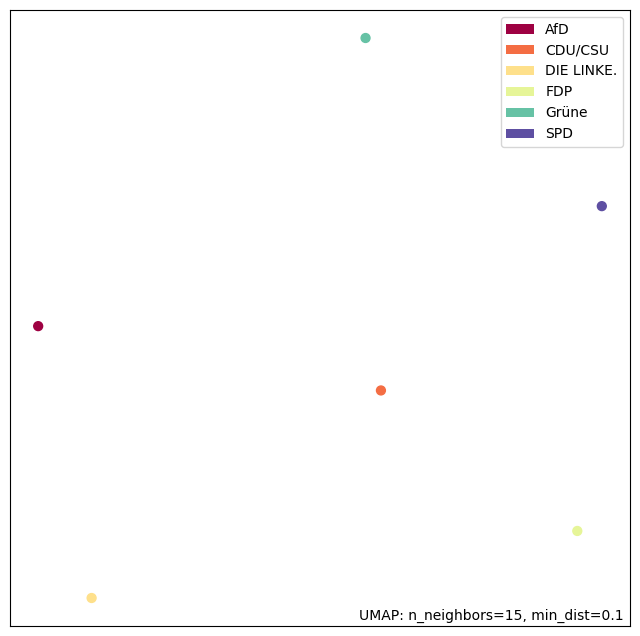

In [44]:
import umap.plot

faction_labels = pd.DataFrame({"factions": embedding_averages.keys()})["factions"]
umap.plot.points(reducer, labels=faction_labels)